In [47]:
import matplotlib.pyplot as plt
from typing import Dict,List
INTERVAL = 100
class DataObject():
    def __init__(self, tag, objId, size, time, end):
        self.tag = tag
        self.objId = objId
        self.size = size
        self.createTime = time
        self.deleteTime = end
        self.requestTmList = []
        self.requestIdList = []
    def request(self, id, time):
        self.requestTmList.append(time)
        self.requestIdList.append(id)
    def delete(self, time):
        self.deleteTime = time
    def getLifeSpan(self):
        return self.deleteTime - self.createTime + 1

class DataSet():
    def __init__(self, dataFile):
        self.dataFile = dataFile
        self.objDict:Dict[int, List[DataObject]] = {}#objid:[obj,],这是为了防止有
        self.getConstant()
        self.countData()
    def getConstant(self):
        '''获取硬件、时间步等信息'''
        with open(self.dataFile, 'r', encoding='utf-8') as file:
            line = file.readline()
            user_input = line.split()
            self.TOLTIME = int(user_input[0])+105
            self.TAGNUM = int(user_input[1])
            self.DISKNUM = int(user_input[2])
            self.UNITNUM = int(user_input[3])
            self.TOKENNUM = int(user_input[4])
    def countData(self):
        '''读取文件，获取存储对象的信息'''
        with open(self.dataFile, 'r', encoding='utf-8') as file:
            lines = file.readlines()
            lineNum = 0
            while(not lines[lineNum].startswith("TIMESTAMP")):
                lineNum+=1
            time = 0
            while(lineNum<len(lines)):
                line = lines[lineNum]
                if(line.startswith("TIMESTAMP")):
                    sline = line.split(' ')
                    assert(len(sline)==2)
                    time = int(sline[1])
                    lineNum += 1
                    continue
                delNum = int(lines[lineNum])
                lineNum += 1
                for i in range(delNum):
                    sline = lines[lineNum]
                    objList = self.objDict.get(int(sline))
                    assert(objList)
                    objList[-1].delete(time)
                    #print('delete on time:'+str(time))
                    lineNum += 1
                wrtNum = int(lines[lineNum])
                lineNum += 1
                for i in range(wrtNum):
                    sline = lines[lineNum].split()
                    dobj = DataObject(int(sline[2]), int(sline[0]), int(sline[1]), time, self.TOLTIME)
                    if(self.objDict.get(int(sline[0]))):
                        self.objDict.get(int(sline[0])).append(dobj)
                    else:
                        self.objDict[int(sline[0])] = [dobj]
                    lineNum += 1
                reqNum = int(lines[lineNum])
                lineNum += 1
                for i in range(reqNum):
                    sline = lines[lineNum].split()
                    objList = self.objDict.get(int(sline[1]))
                    assert(objList)
                    objList[-1].request(sline[0], time)
                    lineNum += 1
    def timeBucketNumByTag(self, interval, tag, type):
        """
        获取以interval为桶宽的时间桶内的属于特定tag的操作对象数目。
        
        Args:
            interval (int) :时间桶的宽度
            tag (int) :对象所属标签
            type (str) :指示获取对象的操作类型
                - 'create':获取时间桶内创建的对象数目
                - 'alive':获取时间桶内存活的对象数目，从create所在桶到delete所在桶(含)都算作存活。
                - 'delete':获取时间桶内删除的对象数目
                - 'request':获取时间桶内请求的对象数目
        Returns:
            list:每个时间桶内的对象数目列表
        """
        bucketNum = [0 for _ in range(int((self.TOLTIME-1)/interval)+1)]
        for key, objList in self.objDict.items():
            for obj in objList:
                if(obj.tag != tag):
                    continue
                if(type == 'create'):
                    bucketNum[int((obj.createTime-1)/interval)] += 1
                elif(type == 'alive'):
                    start = int((obj.createTime-1)/interval)
                    end = int((obj.deleteTime-1)/interval)+1
                    for p in range(start, end):
                        bucketNum[p] += 1
                elif(type == 'delete'):
                    end = int((obj.deleteTime-1)/interval)
                    bucketNum[end] += 1
                elif(type == 'request'):
                    for req in obj.requestTmList:
                        bucketNum[int((req-1)/interval)] += 1
        return bucketNum
    def timeBucketNum(self, interval, type):
        """
        获取以interval为桶宽的时间桶内的操作对象数目。
        
        Args:
            interval (int) :时间桶的宽度
            type (str) :指示获取对象的操作类型
                - 'create':获取时间桶内创建的对象数目
                - 'alive':获取时间桶内存活的对象数目，从create所在桶到delete所在桶(含)都算作存活。
                - 'delete':获取时间桶内删除的对象数目
                - 'request':获取时间桶内请求的对象数目
        Returns:
            list:每个时间桶内的对象数目列表
        """
        bucketNum = [0 for _ in range(int((self.TOLTIME-1)/interval)+1)]
        for key, objList in self.objDict.items():
            for obj in objList:
                if(type == 'create'):
                    bucketNum[int((obj.createTime-1)/interval)] += 1
                elif(type == 'alive'):
                    start = int((obj.createTime-1)/interval)
                    end = int((obj.deleteTime-1)/interval)+1
                    for p in range(start, end):
                        bucketNum[p] += 1
                elif(type == 'delete'):
                    end = int((obj.deleteTime-1)/interval)
                    bucketNum[end] += 1
                elif(type == 'request'):
                    for req in obj.requestTmList:
                        bucketNum[int((req-1)/interval)] += 1
        return bucketNum
    def getNumDivideByTag(self):
        """
        获取创建的不同tag存储对象的数量
        Returns:
            list:属于每个tag的存储对象的数目列表
        """
        bucketNum = [0 for _ in range(self.TAGNUM)]
        for key, objList in self.objDict.items():
            for obj in objList:
                bucketNum[obj.tag-1] += 1
        return bucketNum



In [48]:
# 初始化ds，处理数据
ds = DataSet("sample_practice.in")

Text(0, 0.5, 'create')

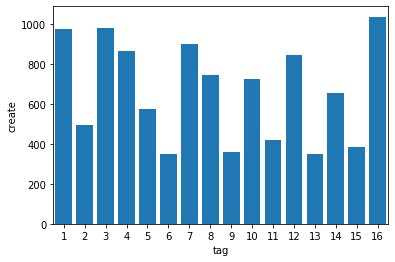

In [49]:
# 验证每个对象id只对应一个对象（即对象id不会轮转复用）
maxLen = 1
for key,objList in ds.objDict.items():
    assert(maxLen == len(objList))
    
# 绘制每个tag的总存储对象数量
taglist = [i+1 for i in range(ds.TAGNUM)]
data = ds.getNumDivideByTag()
#plt.plot(taglist, data, '.')
plt.bar(taglist, data)
plt.xlabel("tag")
plt.xlim(0.5, ds.TAGNUM+0.5)
plt.xticks(taglist)
plt.ylabel("create")

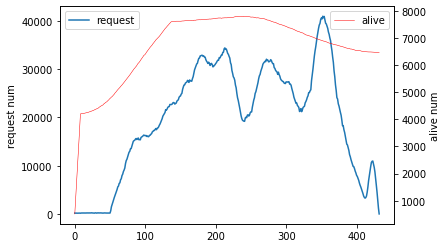

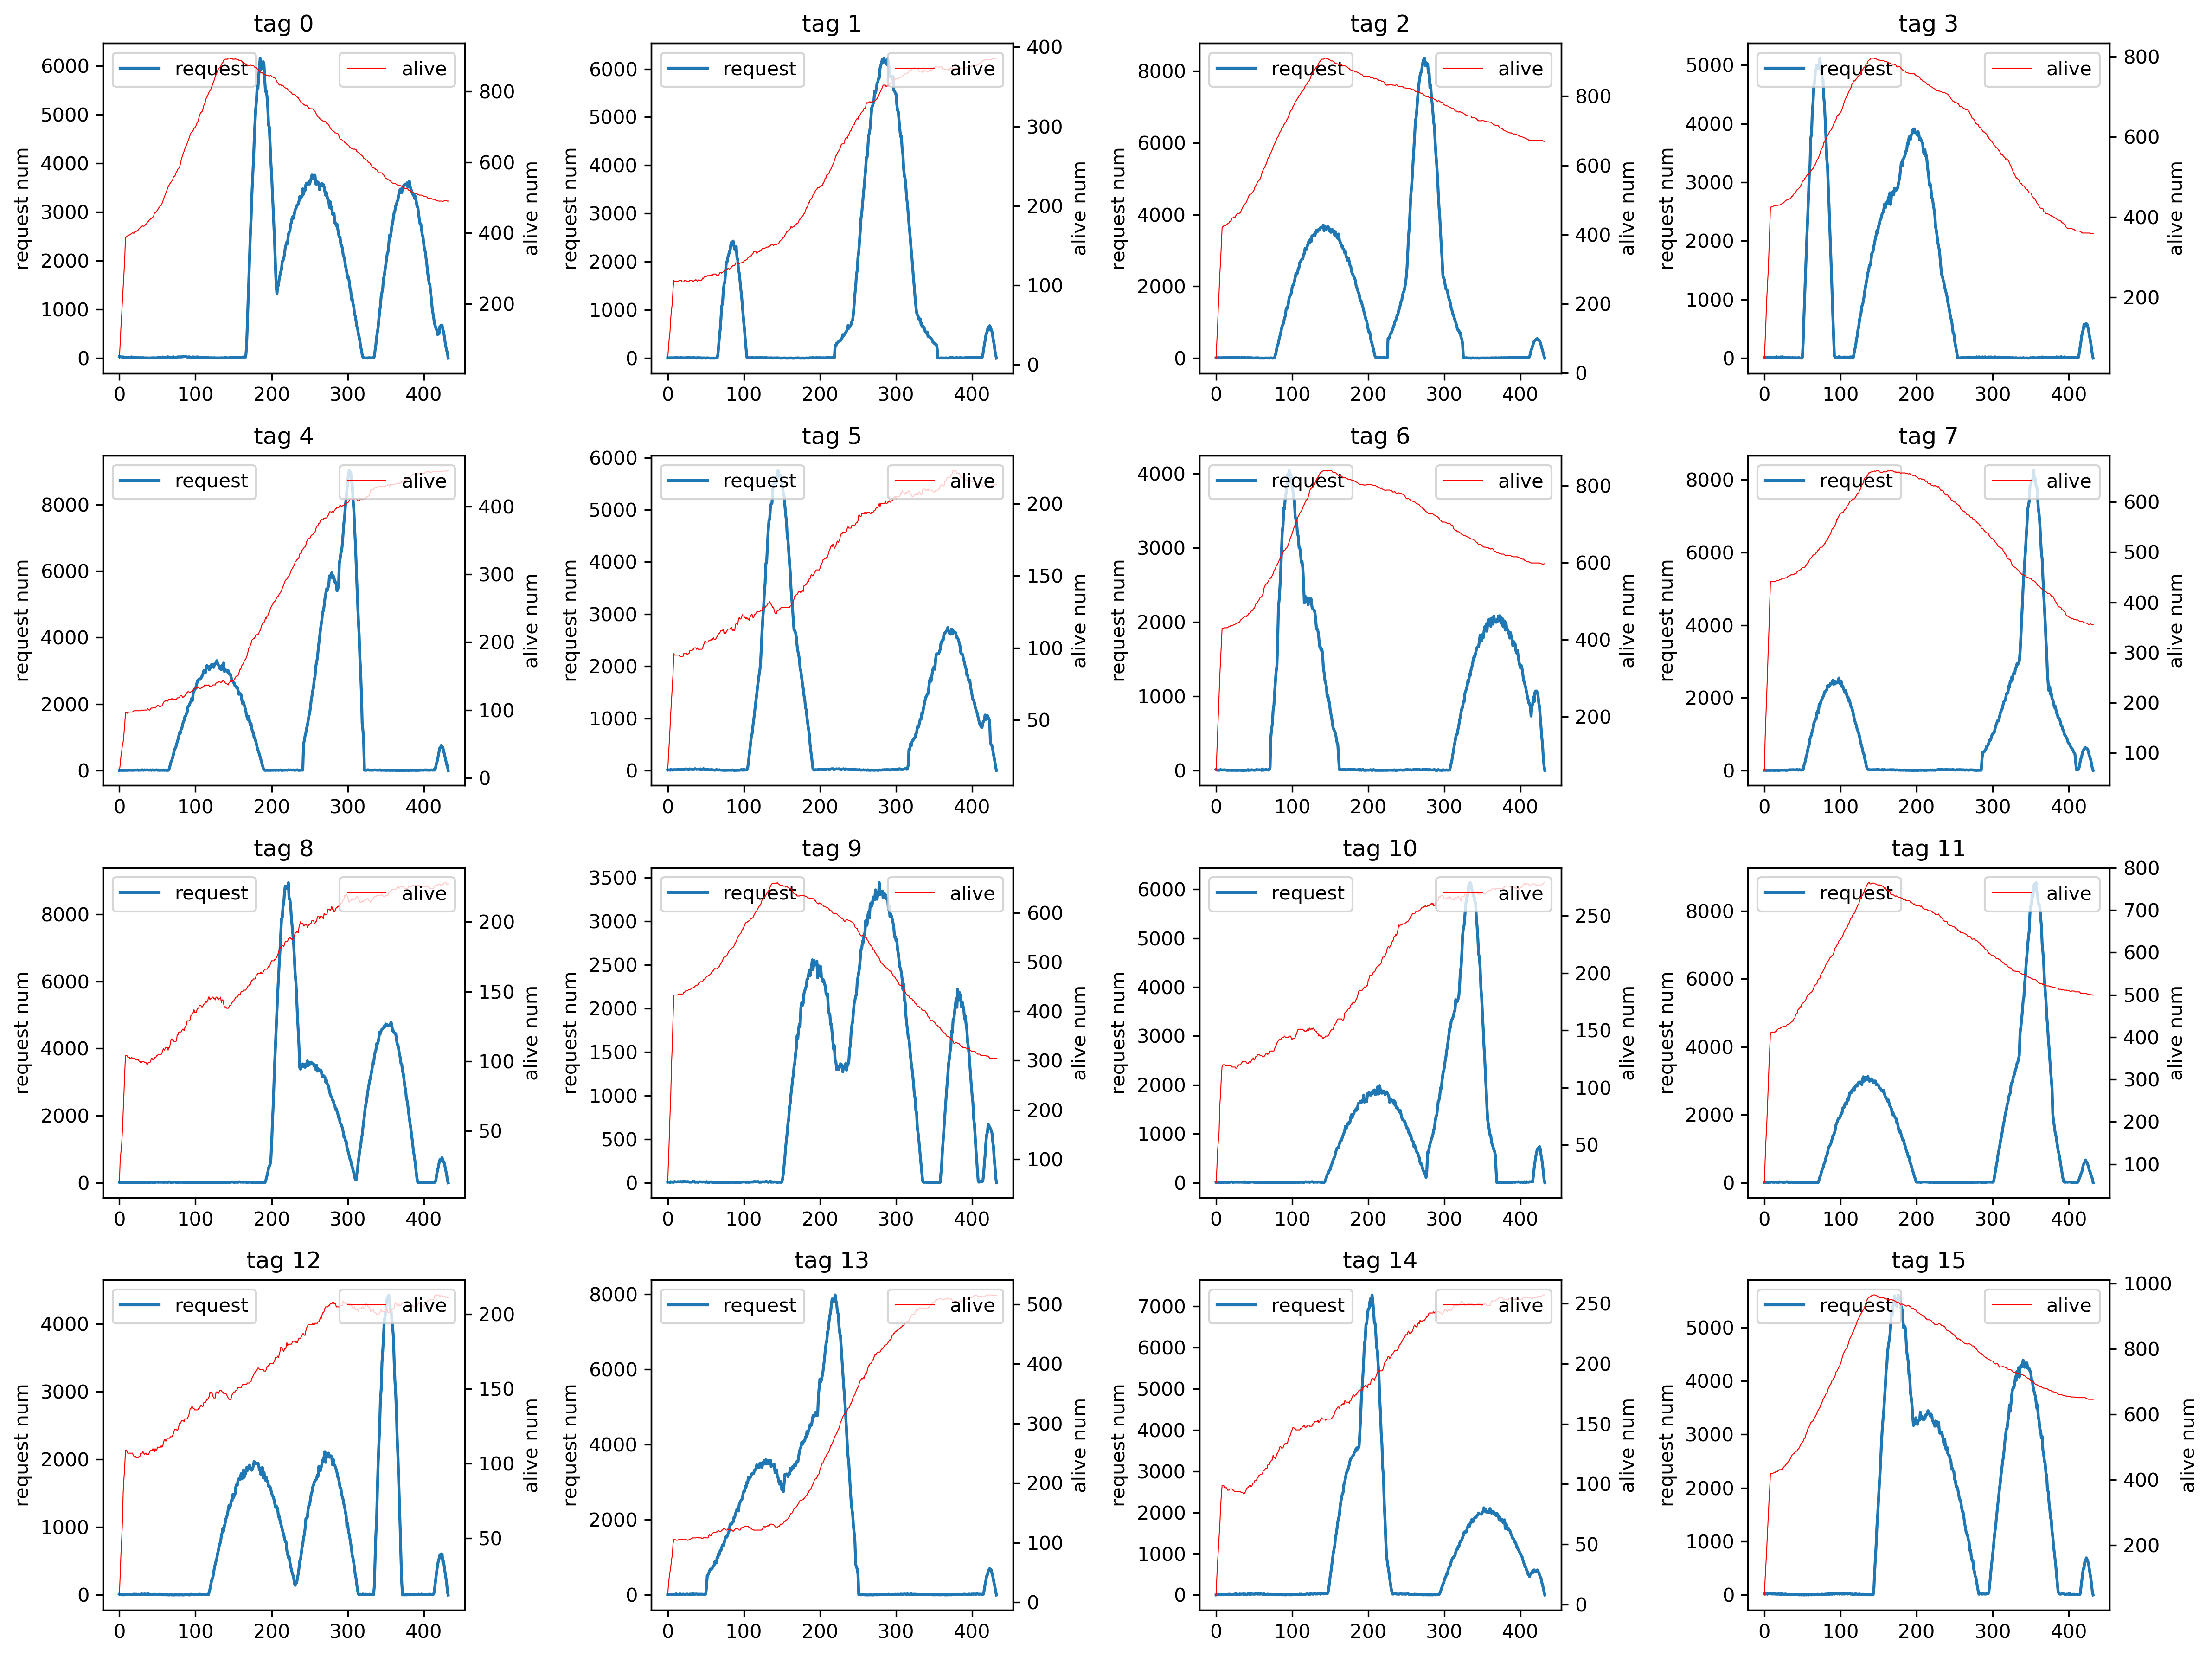

In [ ]:
# 绘制每interval个时间桶内的请求数量及存储对象累积存活数量
interval = 200
tag = ['request', 'alive']

dim = int((ds.TOLTIME-1)/interval)+1
timelist = [i for i in range(dim)]

data = ds.timeBucketNum(interval, tag[0])
axis1 =  plt.subplot()
axis1.plot(timelist, data, label = tag[0])
axis1.set_ylabel('{} num'.format(tag[0]))

data = ds.timeBucketNum(interval, tag[1])
axis2 = axis1.twinx()
axis2.plot(timelist, data, 'r-', linewidth=0.5, label = tag[1])
axis2.set_ylabel('{} num'.format(tag[1]))

axis1.legend(loc = 'upper left')
axis2.legend(loc = 'upper right')

plt.xlabel('time(multiplies {})'.format(interval))
plt.plot()

# 分别绘制每个tag的 每interval个时间步内的请求数量
plt.figure(figsize=(16, 12), dpi=300)
for i in range(ds.TAGNUM):
    axis1 = plt.subplot(4, 4, i+1)
    data = ds.timeBucketNumByTag(interval, i+1, tag[0])
    axis1.plot(timelist, data, label = tag[0])
    axis1.set_ylabel('{} num'.format(tag[0]))
    
    
    axis2 = axis1.twinx()
    data = ds.timeBucketNumByTag(interval, i+1, tag[1])
    axis2.plot(timelist, data, 'r-', linewidth=0.5, label=tag[1])
    axis2.set_ylabel('{} num'.format(tag[1]))
    
    axis1.legend(loc = 'upper left')
    axis2.legend(loc = 'upper right')
    
    plt.title('tag {}'.format(i))
    plt.xlabel('time(multiplies {})'.format(interval))
    plt.tight_layout()
    plt.plot()
# 显示图形
plt.show()

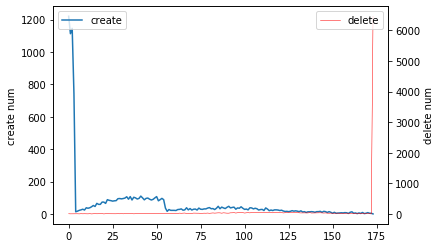

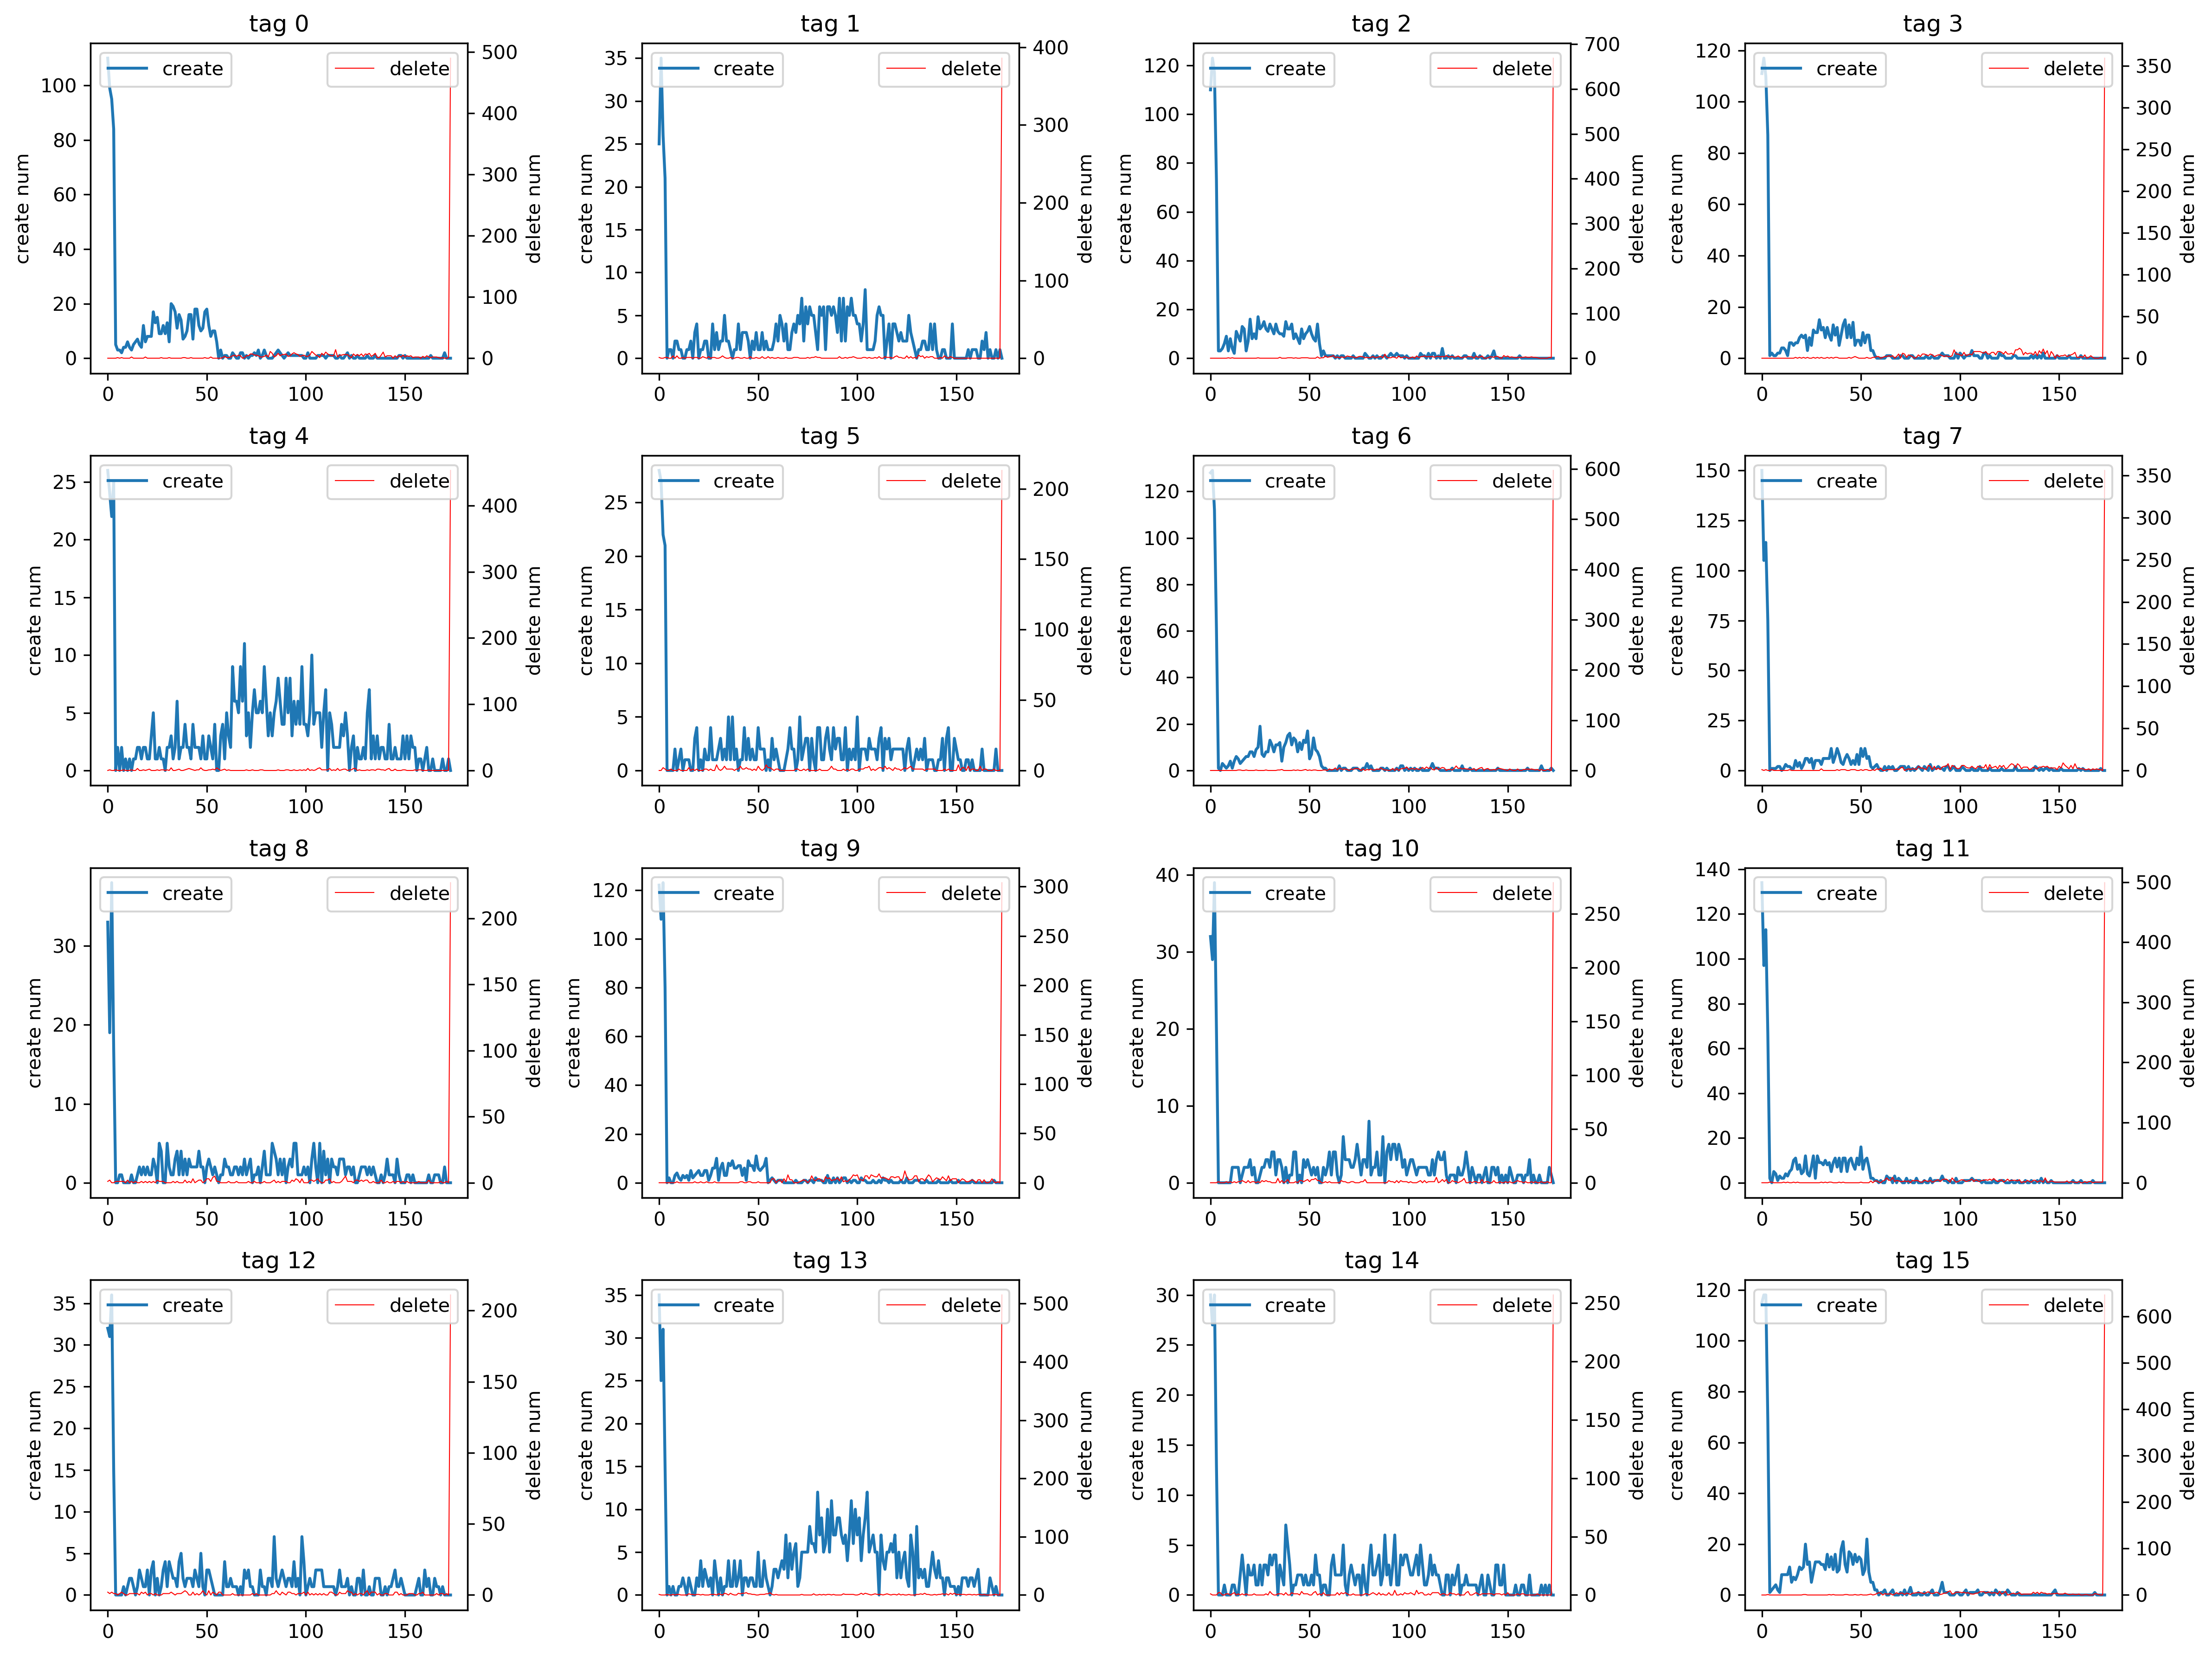

In [51]:
# 绘制每interval个时间步内的对象创建数量和删除数量
interval = 500
dim = int((ds.TOLTIME-1)/interval)+1

timelist = [i for i in range(dim)]
tag = ['create', 'delete']
data = ds.timeBucketNum(interval, tag[0])
axis1 =  plt.subplot()
axis1.plot(timelist, data, label = tag[0])
axis1.set_ylabel('{} num'.format(tag[0]))

data = ds.timeBucketNum(interval, tag[1])
axis2 = axis1.twinx()
axis2.plot(timelist, data, 'r-', linewidth=0.5, label = tag[1])
axis2.set_ylabel('{} num'.format(tag[1]))

axis1.legend(loc = 'upper left')
axis2.legend(loc = 'upper right')

plt.xlabel('time(multiplies {})'.format(interval))
plt.plot()

# 分别绘制每个tag的 每interval个时间步内的请求数量
plt.figure(figsize=(16, 12), dpi=300)
for i in range(ds.TAGNUM):
    axis1 = plt.subplot(4, 4, i+1)
    data = ds.timeBucketNumByTag(interval, i+1, tag[0])
    axis1.plot(timelist, data, label = tag[0])
    axis1.set_ylabel('{} num'.format(tag[0]))
    
    
    axis2 = axis1.twinx()
    data = ds.timeBucketNumByTag(interval, i+1, tag[1])
    axis2.plot(timelist, data, 'r-', linewidth=0.5, label=tag[1])
    axis2.set_ylabel('{} num'.format(tag[1]))
    
    axis1.legend(loc = 'upper left')
    axis2.legend(loc = 'upper right')
    
    plt.title('tag {}'.format(i))
    plt.xlabel('time(multiplies {})'.format(interval))
    plt.tight_layout()
    plt.plot()
# 显示图形
plt.show()